In [1]:
# Imports
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
datasets = [train_data, test_data]

In [3]:
def kmeans_chart(prop, size = 0):
    krange = range(1,size if size > 0 else train_data[prop].value_counts().size)
    inertias = []
    for i in krange:
        kmeans = KMeans(n_clusters=i, random_state=0).fit(train_data[prop].values.reshape(train_data[prop].size,1))
        inertias.append(kmeans.inertia_)

    plt.plot(krange, inertias)
    plt.title(prop)
    plt.xlabel('cluster')
    plt.ylabel('inertia')
def bar_chart(feature):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
def scatter_chart(feature):
    survived = train_data[train_data['Survived']==1][feature]
    dead = train_data[train_data['Survived']==0][feature]
    y_survived = np.ones(survived.size)
    y_dead = np.zeros(dead.size)
    count_survived = survived.value_counts().to_dict()
    size_survived = survived.map(lambda x: count_survived[x]/survived.size*1000)
    count_dead = dead.value_counts().to_dict()
    size_dead = dead.map(lambda x: count_dead[x]/dead.size*1000)
    ax = plt.subplot(111)
#     ax.figure.figsize=[20, 20]
    ax.figure.set_figheight(20)
    ax.figure.set_figwidth(20)
#     ax.figure.colorbar()
    ax.scatter(y_survived, survived, marker='o', s=size_survived, alpha=0.3, cmap='viridis')
    ax.scatter(y_dead, dead, marker='o', c='r', s=size_dead, alpha=0.3)
    
#     plt.colorbar(ax.figure, ax=ax)
    ax.figure.show()

#     plt.scatter(y, survived, marker='o');

def class_distribuition(dataset, feature):
    plt.subplots(figsize = (16,16))
    ax = sns.countplot(x=feature, hue='Survived', data=dataset)
    plt.title('Class distribuition')
    leg = ax.get_legend()
    leg.set_title('Survived')
    legs = leg.texts
    legs[0] = 'No'
    legs[1] = 'Yes'

def distribuition(dataset, feature):
    plt.subplots(figsize = (15,10))
    ax = sns.kdeplot(dataset.loc[(train_data['Survived'] == 0), feature], bw=1, color = 'r', shade=True, label = 'Not survived')
    ax = sns.kdeplot(dataset.loc[(train_data['Survived'] == 1), feature], bw=1, color = 'b', shade=True, label = 'Survived')
    plt.title('%s distribuition' % (feature))
    plt.ylabel('Frequency of survivess')
    plt.xlabel(feature)

In [4]:
train_data.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
names = train_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
train_data['Title'] = names

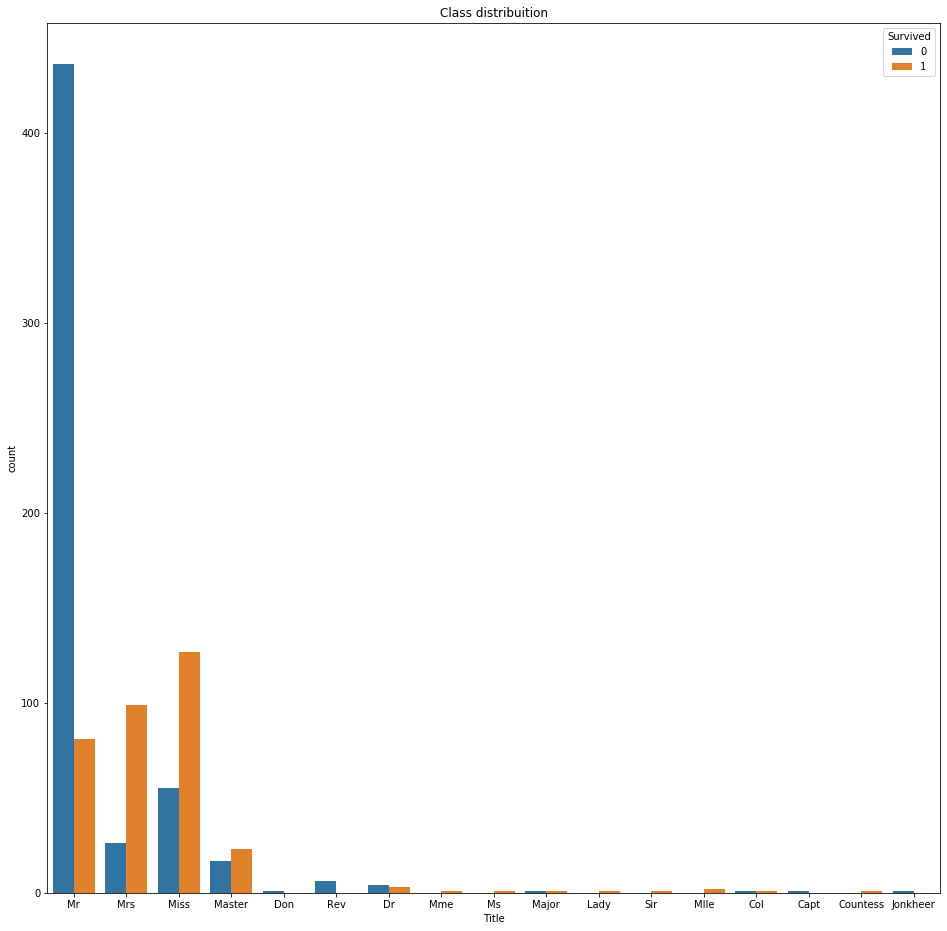

In [6]:
class_distribuition(train_data, 'Title')

In [7]:
# title_mapping = { "Mr": 1,                 
#                  "Major": 2, "Col": 3, "Jonkheer": 4,  
#                  "Don": 5,  "Capt": 6, "Ms": 7, "Sir": 8,  "Rev": 9, 
#                  "Dr": 10, "Master": 11,
#                  "Mrs": 12,
#                  "Miss": 13, "Mlle": 14, "Mme": 15, "Dona": 16, "Lady": 17, "Countess": 18, 'scott': 19    
#                   }
title_mapping = { "Mr": 0.156673,                 
                 "Major": 0.266667, "Col": 0.266667, "Jonkheer": 0.266667,  
                 "Don": 0.266667,  "Capt": 0.266667, "Ms": 0.266667, "Sir": 0.266667,  "Rev": 0.266667, 
                 "Dr": 0.553191, "Master": 0.553191,
                 "Mrs": 0.792000,
                 "Miss": 0.705882, "Mlle": 0.705882, "Mme": 0.705882, "Dona": 0.705882, "Lady": 0.705882, "Countess": 0.705882          
                  }
train_data['CTitle'] = names.map(title_mapping)


title_scaller = StandardScaler()
train_data['CTitle'] = title_scaller.fit_transform(train_data['CTitle'].values.reshape(-1,1), train_data['Survived'])

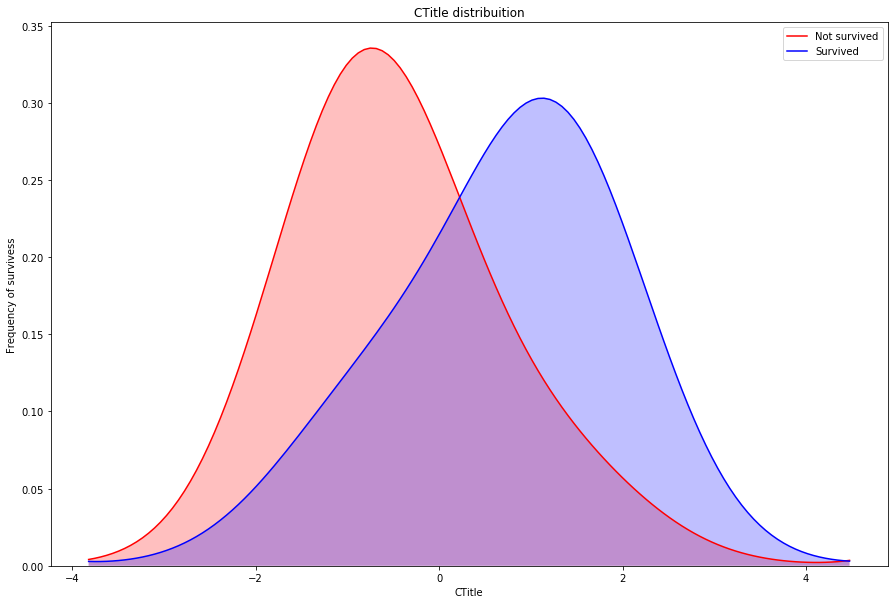

In [8]:
# train_data.groupby('CTitle')['Survived'].describe()
# class_distribuition(train_data, 'CTitle')
# train_data['CTitle'] = 
distribuition(train_data, 'CTitle')

In [9]:
train_data['Omg'] = 0
groups = train_data.groupby('Ticket').groups

# pairs = list(filter(lambda x: groups[x].size >= 2, groups))
for group in groups:
    if(groups[group].size >= 2 ):
        for pearson in groups[group]:
            info = train_data.loc[pearson]
            corr = info['Parch'] + info['SibSp']
            if(corr > groups[group].size):
                train_data.at[pearson, 'Omg'] = corr

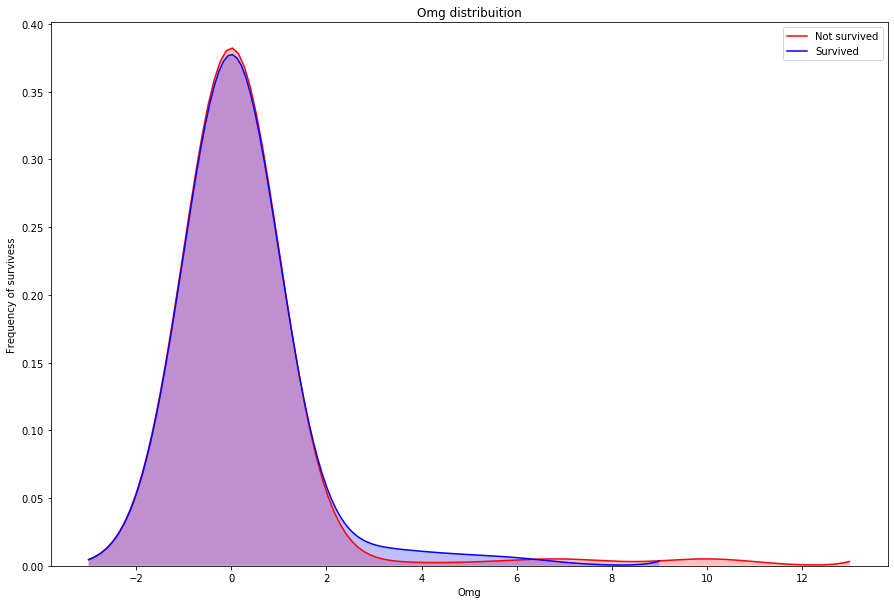

In [10]:
distribuition(train_data, 'Omg')


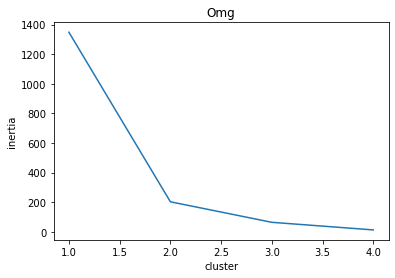

In [11]:
kmeans_chart('Omg', 5)

In [12]:
kmeans_omg = KMeans(n_clusters=2, random_state=0).fit(train_data.Omg.values.reshape(train_data.Omg.values.size, 1))
def transform_omg(val):
    return kmeans_omg.predict([[val]])[0]

omg_mapping = {
    0: 0.380841,
    1: 0.176471,
    2: 0.722222
}
train_data['COmg'] = train_data['Omg'].map(transform_omg)
# train_data['COmg'] = train_data['Omg'].map(omg_mapping)
train_data.groupby('COmg')['Survived'].describe()


,count,mean,std,min,25%,50%,75%,max
COmg,,,,,,,,
0,867.0,0.385236,0.486932,0.0,0.0,0.0,1.0,1.0
1,24.0,0.333333,0.481543,0.0,0.0,0.0,1.0,1.0


In [13]:
omg_scaller = StandardScaler()
train_data['COmg'] = omg_scaller.fit_transform(train_data['COmg'].values.reshape(-1,1), train_data['Survived'])

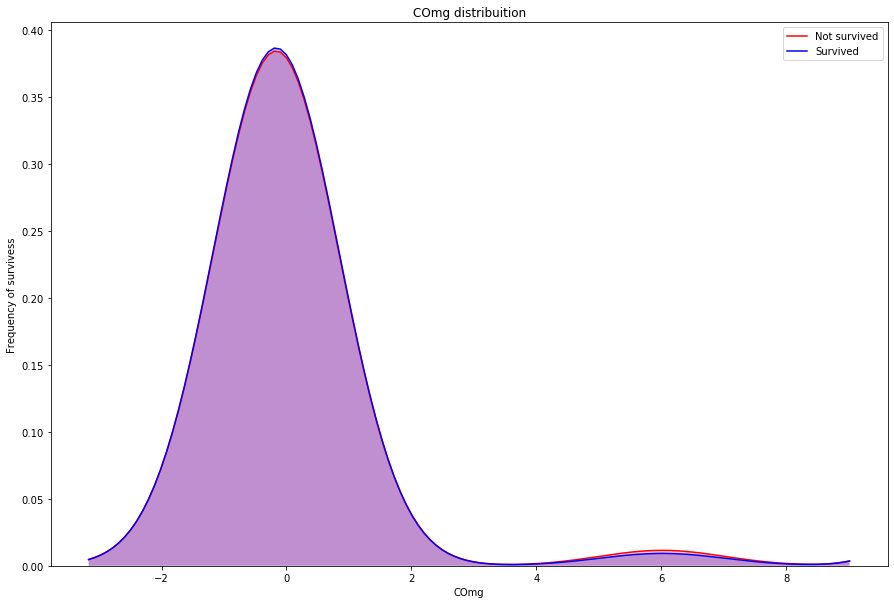

In [14]:
distribuition(train_data, 'COmg')

In [15]:
# train_data['CSibSp'] = train_data['SibSp'].map(transform_sibsp)
# # 
# sibsp_scaller = StandardScaler()
# train_data['CSibSp'] = sibsp_scaller.fit_transform(train_data['CGSibSp'].values.reshape(-1,1), train_data['Survived'])

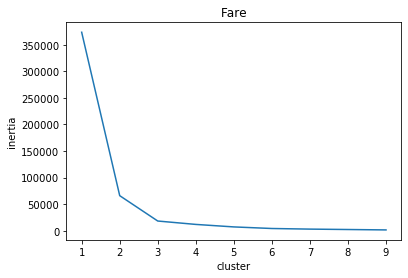

In [16]:
def fare_outliers(row):
    distance = 1.5 * (np.percentile(train_data['Fare'], 75) - np.percentile(train_data['Fare'], 25))
    if(row['Fare'] > distance + np.percentile(train_data['Fare'], 75)):
        row['Fare'] = distance + np.percentile(train_data['Fare'], 75)
    elif(row['Fare'] < np.percentile(train_data['Fare'], 25) - distance):
        row['Fare'] = np.percentile(train_data['Fare'], 25) - distance
    return row

train_data = train_data.apply(fare_outliers, axis=1)
kmeans_chart('Fare', 10)
kmeans_fare = KMeans(n_clusters=3, random_state=0).fit(train_data.Fare.values.reshape(train_data.Fare.size,1))
def transform_fare(val):
    return kmeans_fare.predict([[val]])[0]
train_data['CFare'] =  train_data['Fare'].map(transform_fare)

In [17]:
train_data.groupby('CFare')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
CFare,,,,,,,,
0,218.0,0.449541,0.498592,0.0,0.0,0.0,1.0,1.0
1,171.0,0.649123,0.478646,0.0,0.0,1.0,1.0,1.0
2,502.0,0.264940,0.441742,0.0,0.0,0.0,1.0,1.0


In [18]:
fare_mapping = {
    0: 0.449541,
    1: 0.649123,
    2: 0.264940
}
train_data['CFare'] = train_data['CFare'].map(fare_mapping)

In [19]:
# class_distribuition(train_data, 'CFare')
fare_scaller = StandardScaler()
train_data['CFare'] = fare_scaller.fit_transform(train_data['CFare'].values.reshape(-1,1), train_data['Survived'])

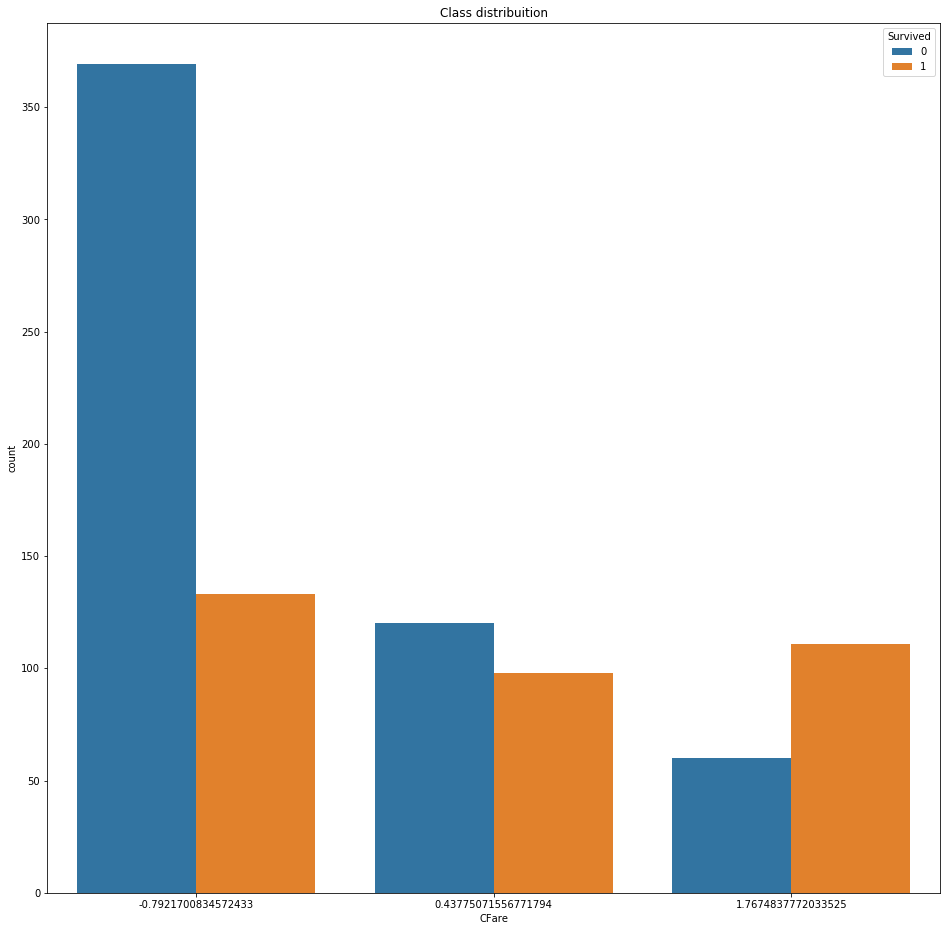

In [20]:
class_distribuition(train_data, 'CFare')

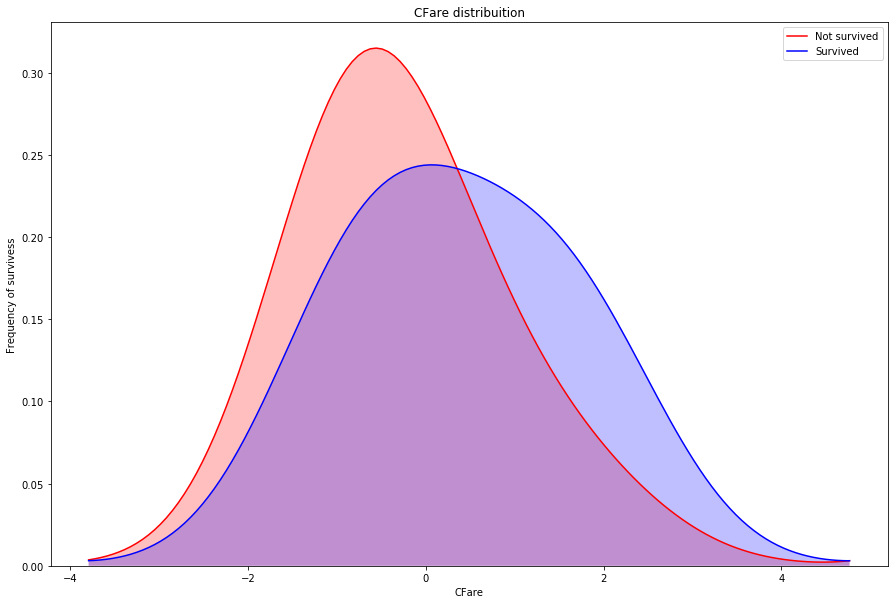

In [21]:
distribuition(train_data, 'CFare')

In [22]:
sex_mapping = { "male": 0, "female": 1}
train_data['Sex'] = train_data.Sex.map(sex_mapping)

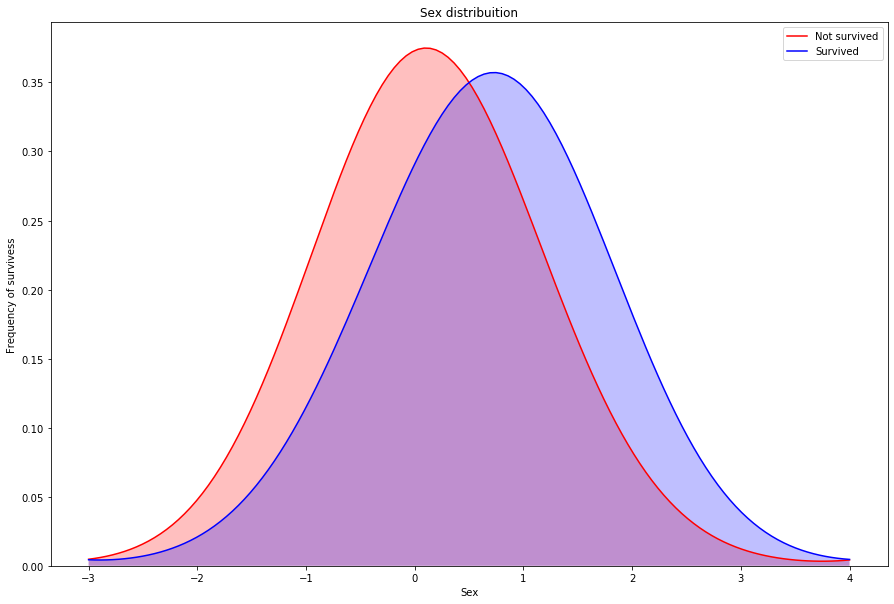

In [23]:
distribuition(train_data, 'Sex')

In [24]:
train_data['Embarked'].fillna('C', inplace=True)
embarked_mapping = { "S": 0.336957, "C": 0.389610, "Q": 0.558824 }

train_data['CEmbarked'] = train_data.Embarked.map(embarked_mapping)

embarked_scaller = StandardScaler()
train_data['CEmbarked'] = embarked_scaller.fit_transform(train_data['CEmbarked'].values.reshape(-1,1), train_data['Survived'])


In [25]:
train_data.groupby('Embarked')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,170.0,0.558824,0.497995,0.0,0.0,1.0,1.0,1.0
Q,77.0,0.389610,0.490860,0.0,0.0,0.0,1.0,1.0
S,644.0,0.336957,0.473037,0.0,0.0,0.0,1.0,1.0


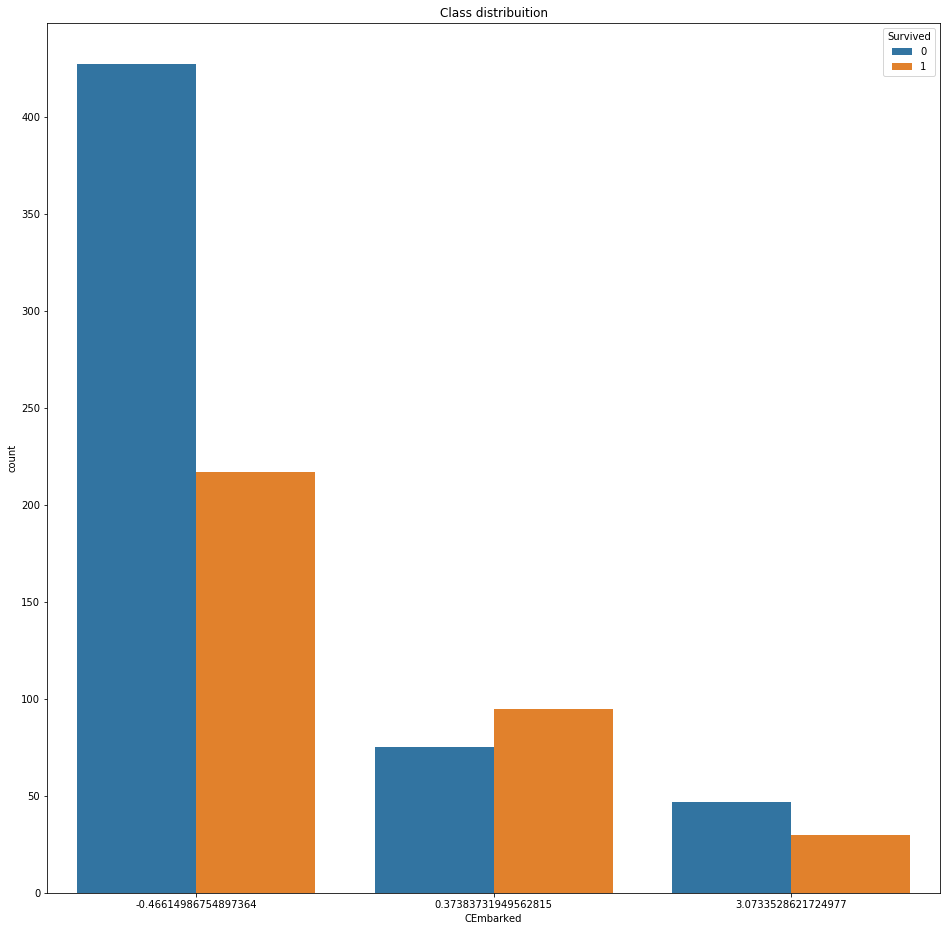

In [26]:
class_distribuition(train_data, 'CEmbarked')

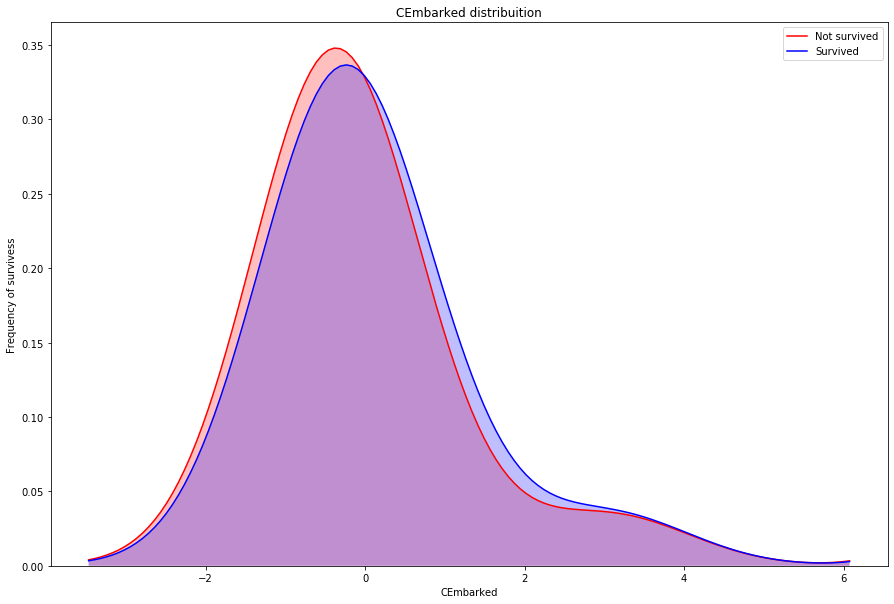

In [27]:
distribuition(train_data, 'CEmbarked')

In [28]:
means = train_data.groupby('Title')['Age'].mean().to_dict()
median = train_data['Age'].mean()
def median_age(row):
    if(np.isnan(row['Age'])):
        row['Age'] = means[row['Title']]
#         row['Age'] = median
    return row


# asd = age_test.fillna(train_data.groupby('Title')['Age'].mean().to_dict(), axis='Title')

train_data = train_data.apply(median_age, axis=1)

In [29]:
def age_outliers(row):
    distance = 1.5 * (np.percentile(train_data['Age'], 75) - np.percentile(train_data['Age'], 25))
    if(row['Age'] > distance + np.percentile(train_data['Age'], 75)):
        row['Age'] = distance + np.percentile(train_data['Age'], 75)
    elif(row['Age'] < np.percentile(train_data['Age'], 25) - distance):
        row['Age'] = np.percentile(train_data['Age'], 25) - distance
    return row

train_data = train_data.apply(age_outliers, axis=1)

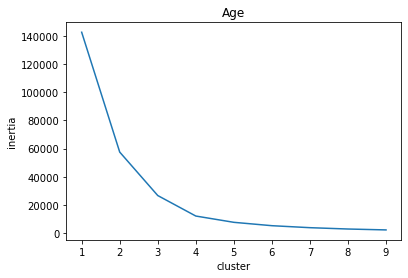

In [30]:
kmeans_chart('Age', 10)

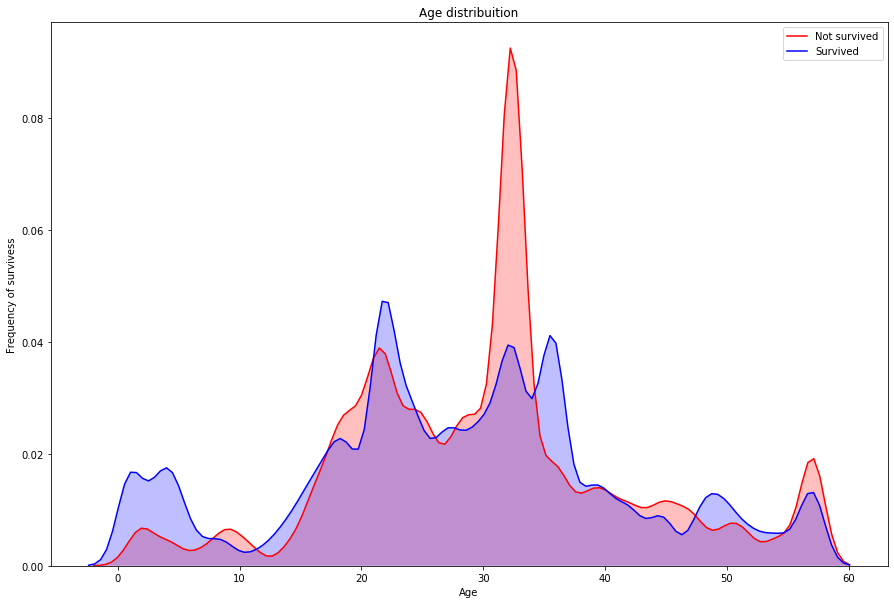

In [31]:
distribuition(train_data, 'Age')

In [80]:
kmeans_age = KMeans(n_clusters=7, random_state=0).fit(train_data.Age.values.reshape(train_data.Age.values.size, 1))
def transform_age(val):
    return kmeans_age.predict([[val]])[0]

train_data['CGAge'] = train_data['Age'].map(transform_age)

age_mapping = {
    0: 0.369128,
    1: 0.447950,
    2: 0.341176
}
train_data['CAge'] = train_data['CGAge'].map(age_mapping)

age_scaller = StandardScaler()
train_data['CAge'] = age_scaller.fit_transform(train_data['Age'].values.reshape(-1,1), train_data['Survived'])


In [72]:
train_data.groupby('CGAge')['Survived'].describe()
# transform_age(12)

,count,mean,std,min,25%,50%,75%,max
CGAge,,,,,,,,
0,109.0,0.366972,0.484205,0.0,0.0,0.0,1.0,1.0
1,286.0,0.391608,0.488965,0.0,0.0,0.0,1.0,1.0
2,343.0,0.341108,0.474774,0.0,0.0,0.0,1.0,1.0
3,73.0,0.575342,0.497712,0.0,0.0,1.0,1.0,1.0
4,80.0,0.387500,0.490253,0.0,0.0,0.0,1.0,1.0


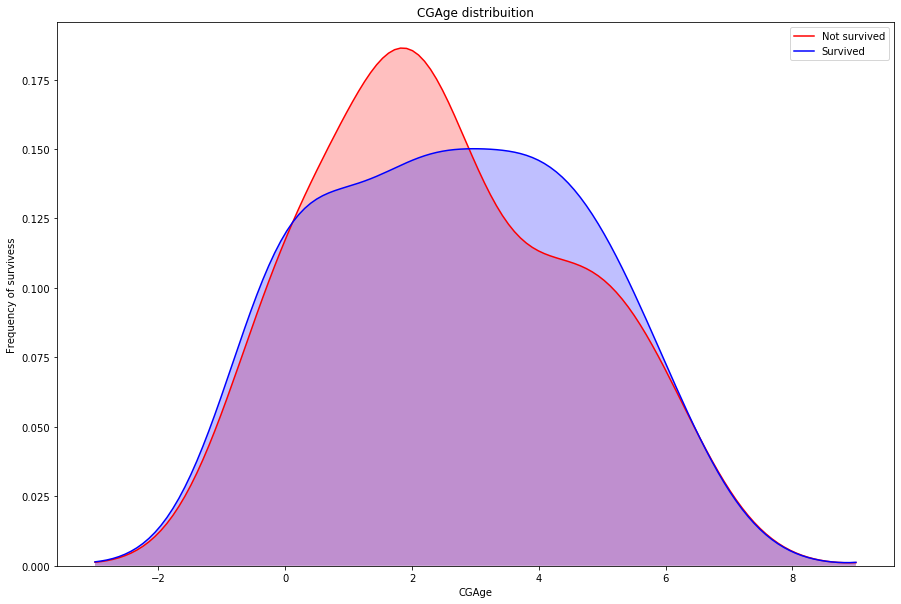

In [81]:
distribuition(train_data, 'CGAge')

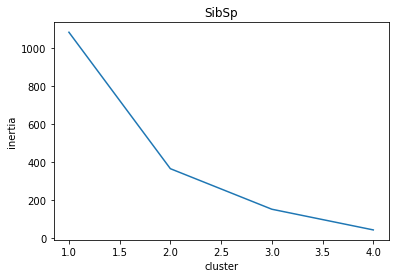

In [35]:
kmeans_chart('SibSp', 5)

In [36]:
kmeans_sibsp = KMeans(n_clusters=2, random_state=0).fit(train_data.SibSp.values.reshape(train_data.SibSp.values.size, 1))
def transform_sibsp(val):
    return kmeans_sibsp.predict([[val]])[0]

train_data['CGSibSp'] = train_data['SibSp'].map(transform_sibsp)
train_data['CSibSp'] = train_data['SibSp'].map(transform_sibsp)
# 
sibsp_scaller = StandardScaler()
train_data['CSibSp'] = sibsp_scaller.fit_transform(train_data['CGSibSp'].values.reshape(-1,1), train_data['Survived'])

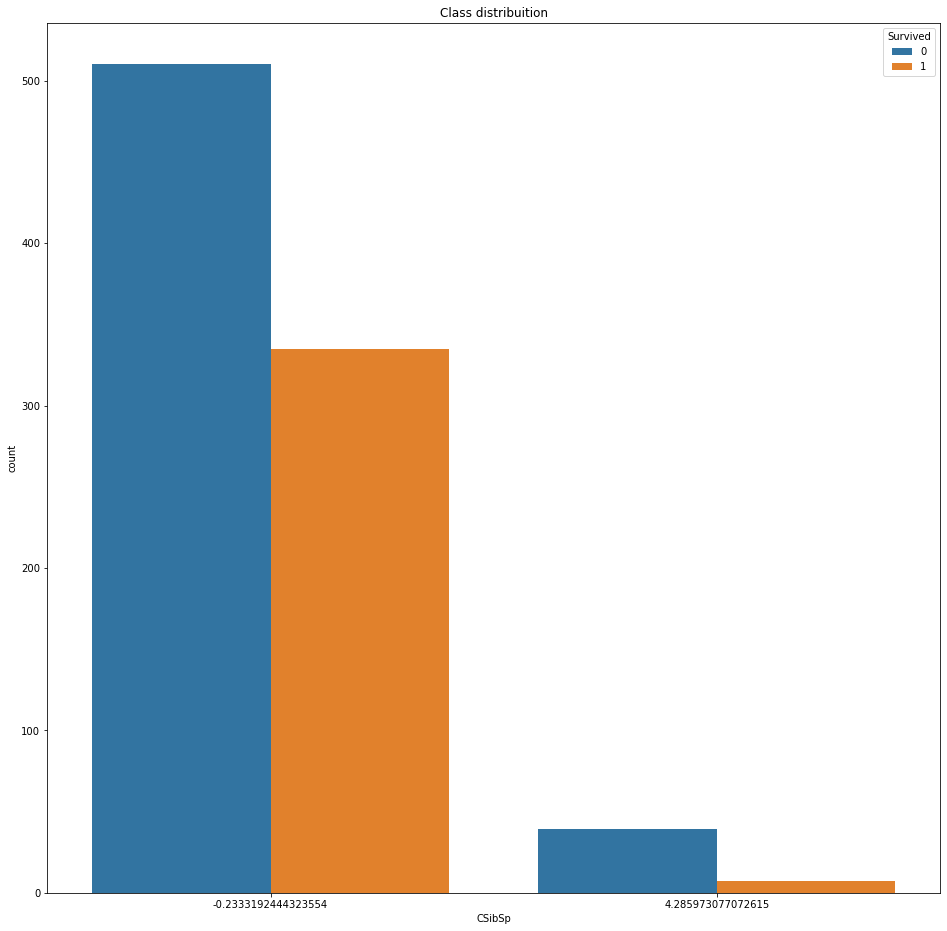

In [37]:
class_distribuition(train_data, 'CSibSp')

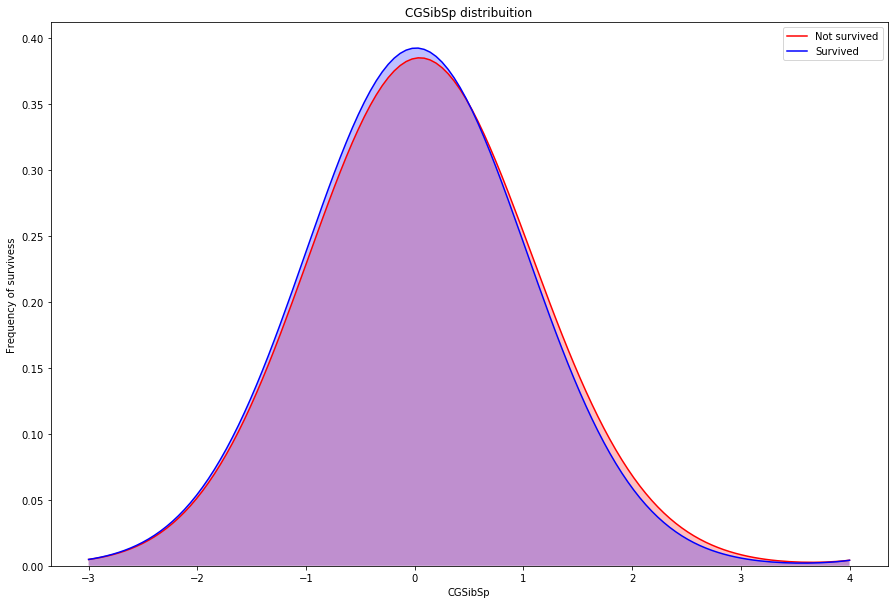

In [38]:
distribuition(train_data, 'CGSibSp')

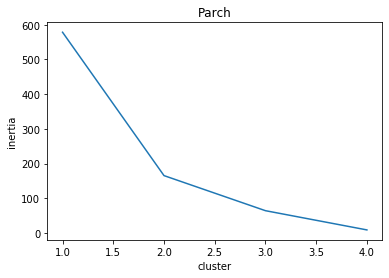

In [39]:
kmeans_chart('Parch', 5)

In [40]:
kmeans_parch = KMeans(n_clusters=2, random_state=0).fit(train_data.Parch.values.reshape(train_data.Parch.values.size, 1))
def transform_parch(val):
    return kmeans_parch.predict([[val]])[0]
train_data['CGParch'] = train_data['Parch'].map(transform_parch)
train_data['CParch'] = train_data['Parch'].map(transform_parch)
parch_scaller = StandardScaler()
train_data['CParch'] = parch_scaller.fit_transform(train_data['CGParch'].values.reshape(-1,1), train_data['Survived'])


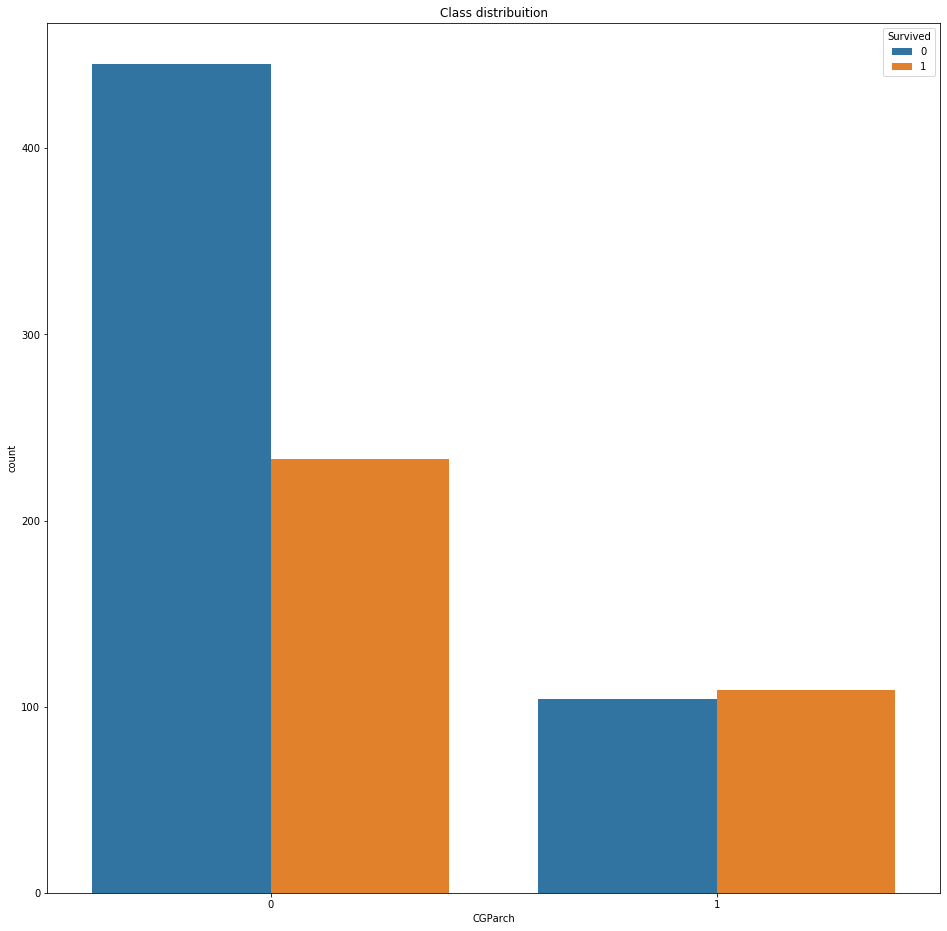

In [41]:
class_distribuition(train_data, 'CGParch')

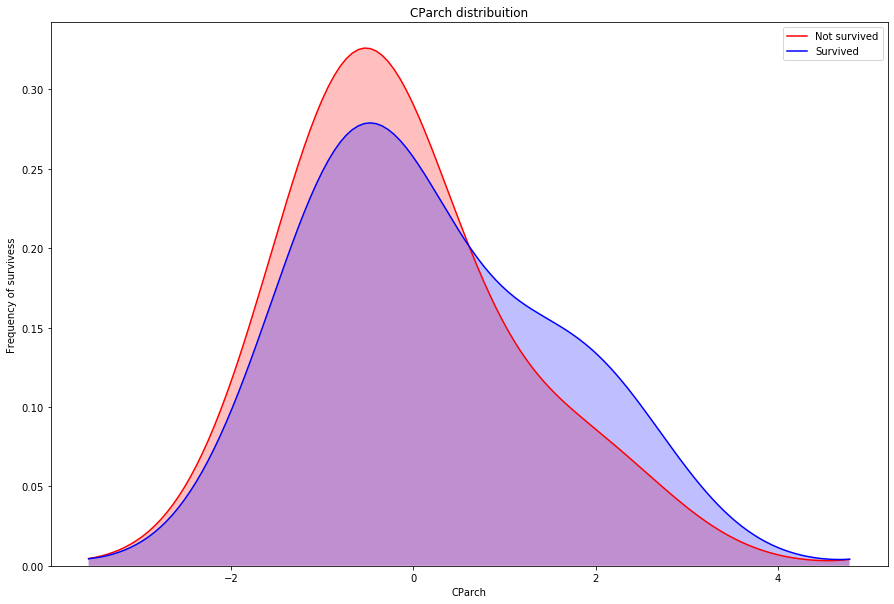

In [42]:
distribuition(train_data, 'CParch')

In [43]:
train_data['Parents'] = train_data['Parch'] + train_data['SibSp'] + 1


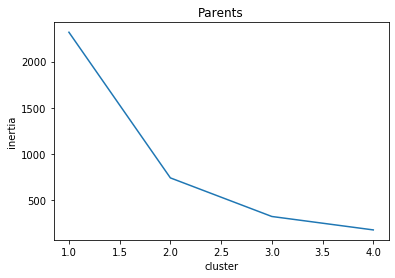

In [44]:
kmeans_chart('Parents', 5)

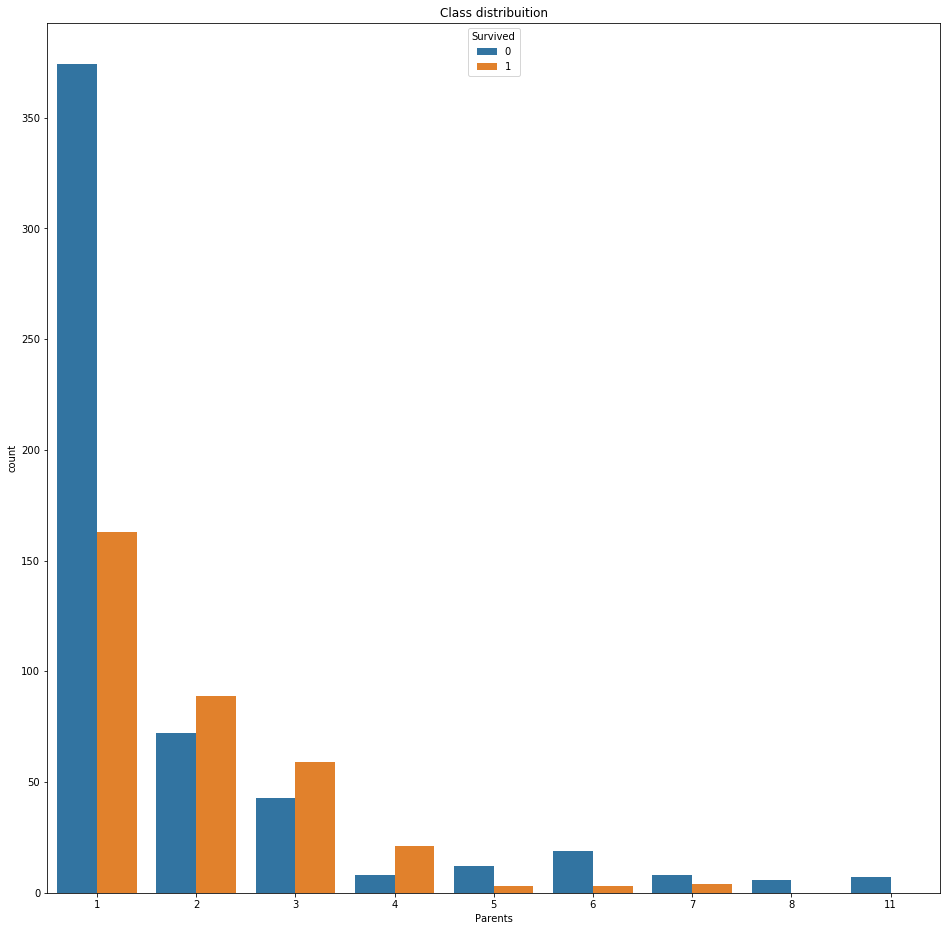

In [45]:
class_distribuition(train_data, 'Parents')
# parent_mapping = {
#     0: 0.303538,
#     1: 0.562738, 2: 0.562738,
#     3: 0.545455, 4: 0.545455,
#     5: 0.148936, 6: 0.148936, 7: 0.148936, 8: 0.148936, 9: 0.148936, 10: 0.148936, 11: 0.148936, 12: 0.148936
# }
parent_mapping = {
    0: 0.303538,
    1: 0.161290,
    2: 0.578767
}
kmeans_parent = KMeans(n_clusters=3, random_state=0).fit(train_data.Parents.values.reshape(train_data.Parents.values.size, 1))
def transform_parent(val):
    return kmeans_parent.predict([[val]])[0]
train_data['CGParents'] = train_data['Parents'].map(transform_parent)

train_data['CParents'] = train_data['CGParents'].map(parent_mapping)

parent_scaller = StandardScaler()
train_data['CParents'] = parent_scaller.fit_transform(train_data['CParents'].values.reshape(-1,1), train_data['Survived'])


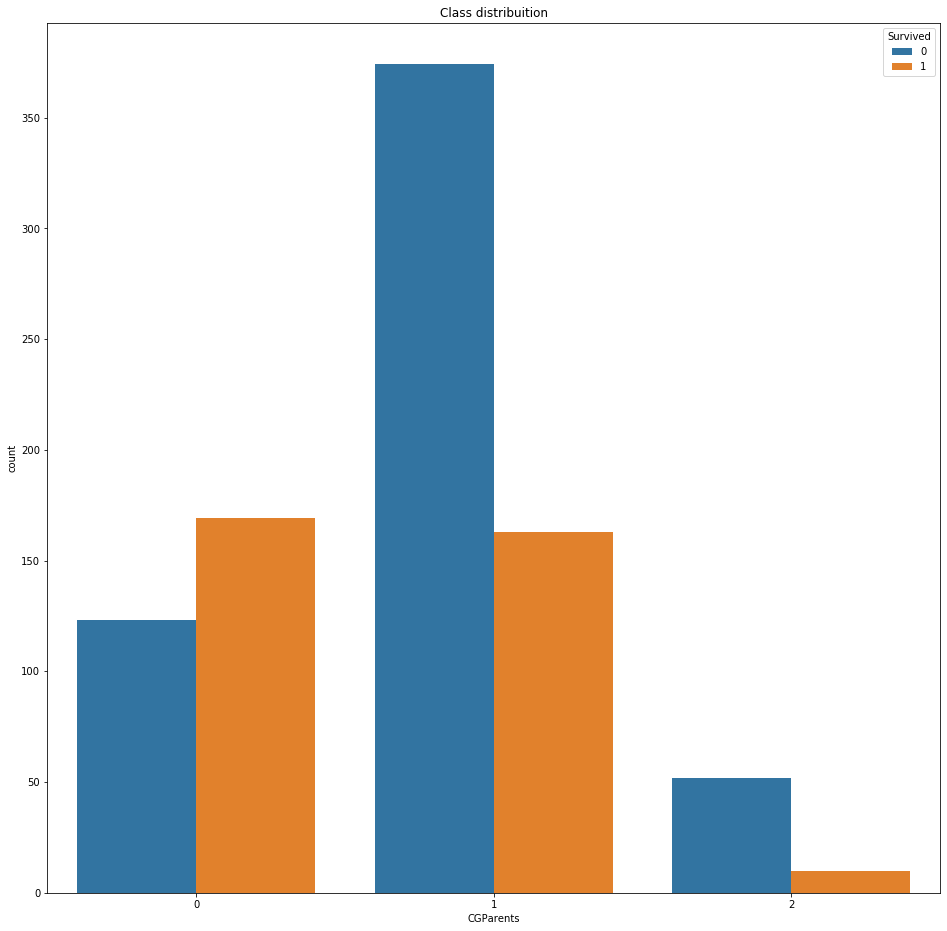

In [46]:
class_distribuition(train_data, 'CGParents')

In [47]:
train_data.groupby('CParents')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
CParents,,,,,,,,
-0.662800,537.0,0.303538,0.460214,0.0,0.0,0.0,1.0,1.0
0.583199,292.0,0.578767,0.494604,0.0,0.0,1.0,1.0,1.0
2.994023,62.0,0.161290,0.370801,0.0,0.0,0.0,0.0,1.0


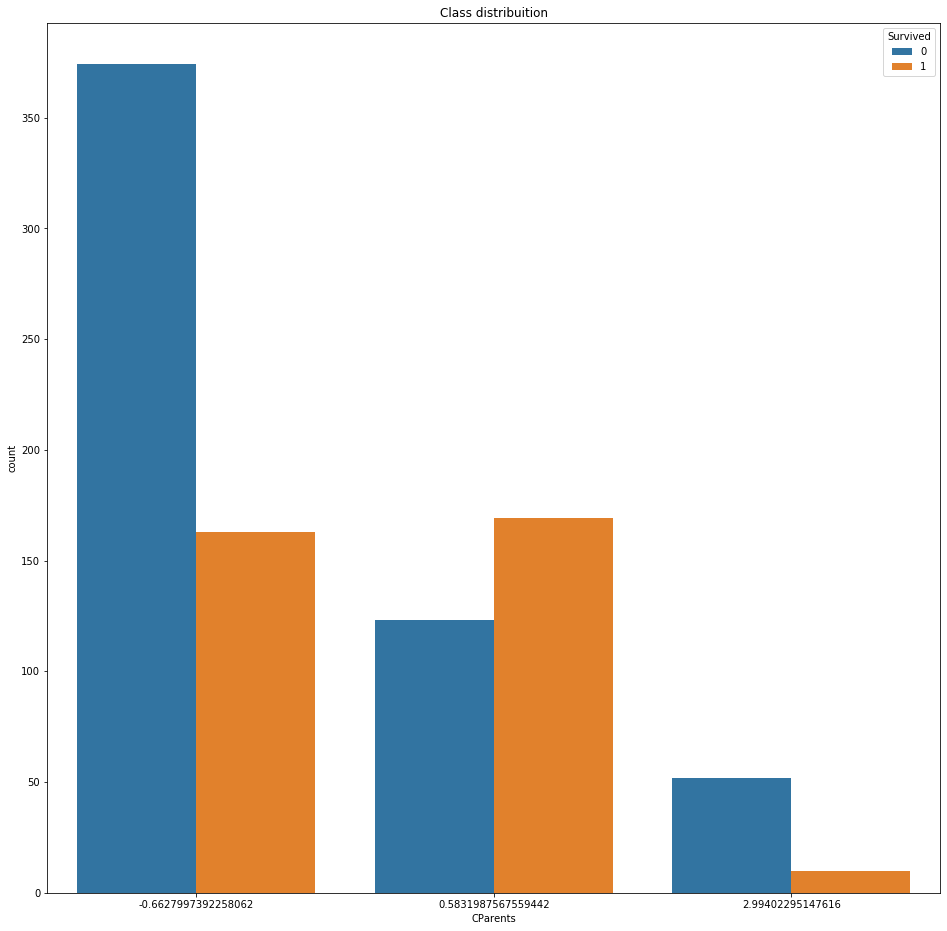

In [48]:
class_distribuition(train_data, 'CParents')
# 
# train_data['CParents'].isnull()
# train_data.isnull().sum()

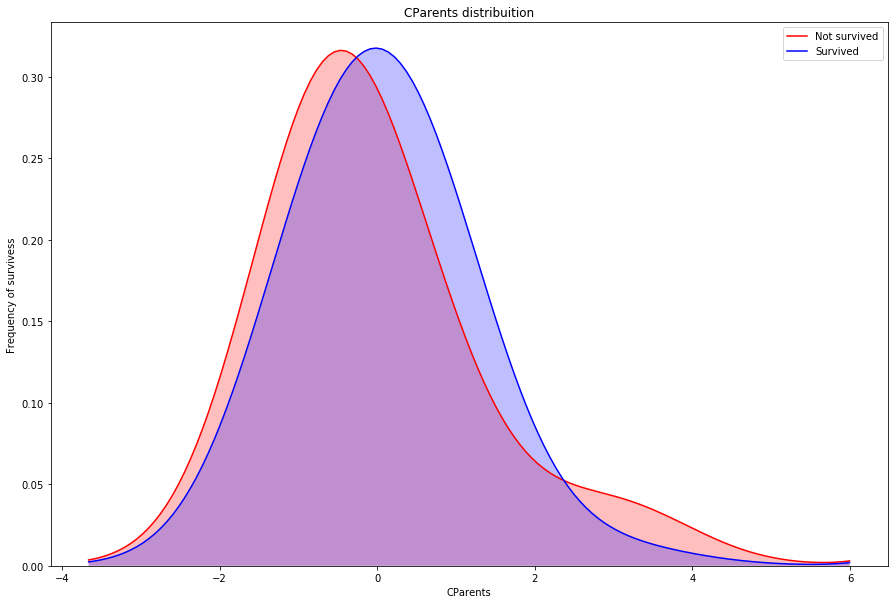

In [49]:
distribuition(train_data, 'CParents')

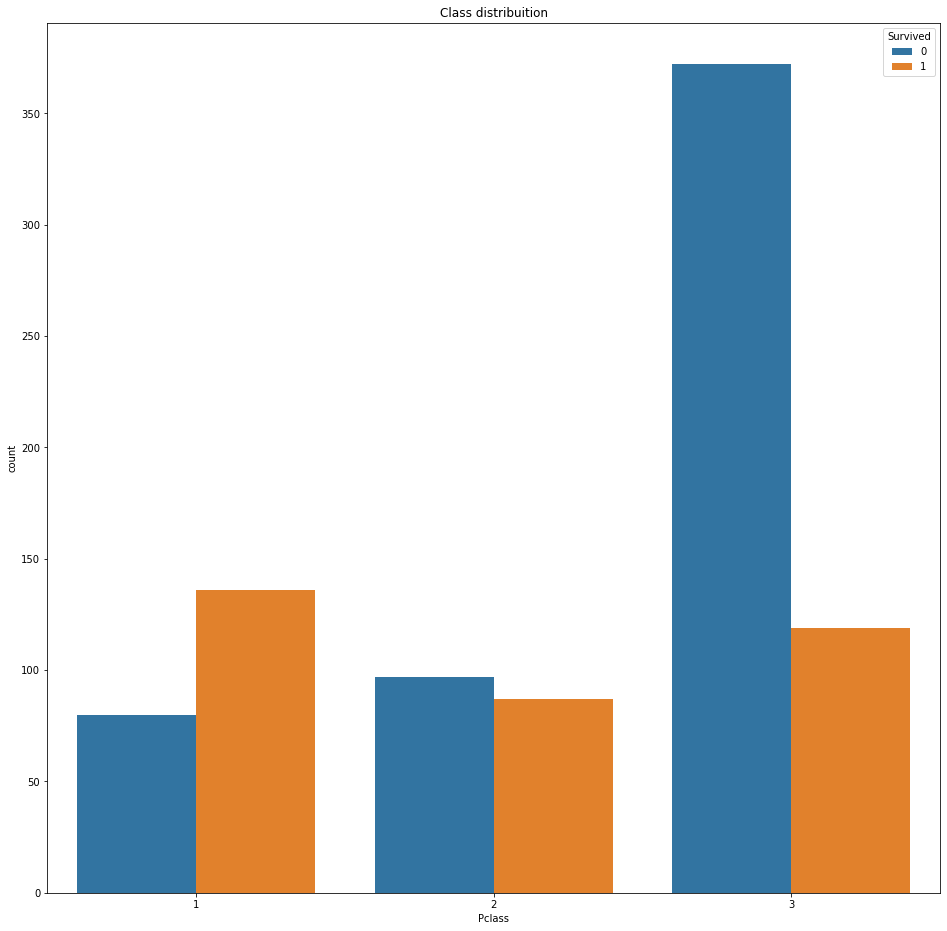

In [50]:
class_distribuition(train_data,'Pclass')

class_mapping = {
    3: 0.2423,
    2: 0.472826,
    1: 0.629630
}

train_data['CPclass'] = train_data['Pclass'].map(class_mapping)
class_scaller = StandardScaler()
train_data['CPclass'] = class_scaller.fit_transform(train_data['CPclass'].values.reshape(-1,1), train_data['Survived'])


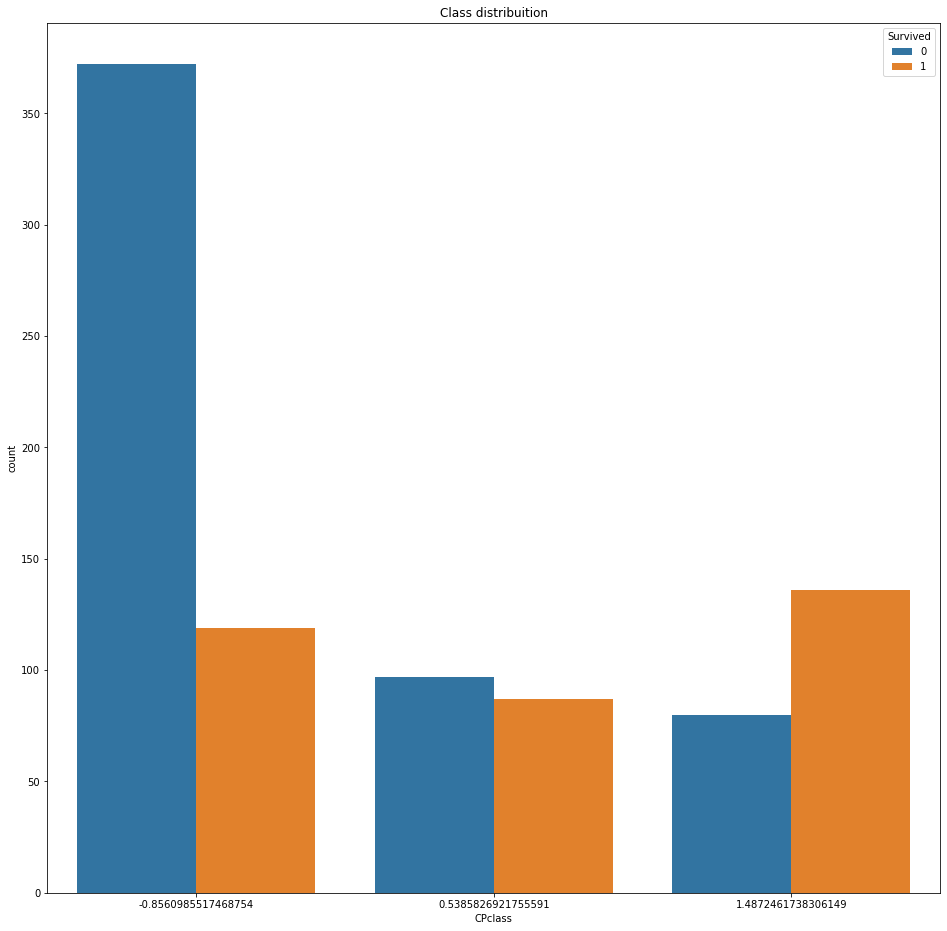

In [51]:
class_distribuition(train_data, 'CPclass')

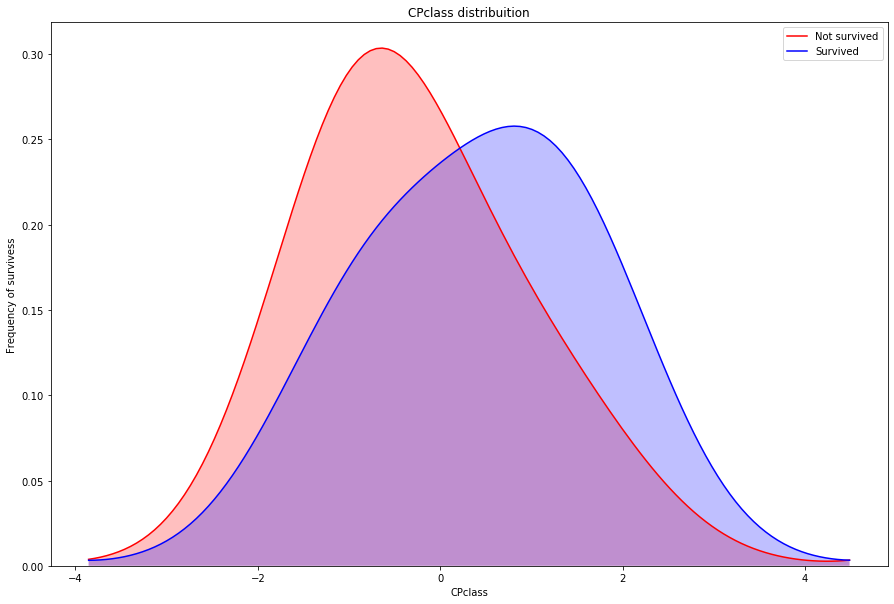

In [52]:
distribuition(train_data, 'CPclass')

In [53]:
y = train_data['Survived']
features = ['CPclass', 'CAge', 'CParents', 'CFare', 'Sex', 'CEmbarked', 'CSibSp', 'CParch', 'CTitle', 'COmg']
analyse = train_data[['CPclass', 'CAge', 'CParents', 'CFare', 'Sex', 'CEmbarked', 'CSibSp', 'CParch','COmg', 'Survived']]
X = train_data[features]


Text(0.5, 1, 'Correlations')

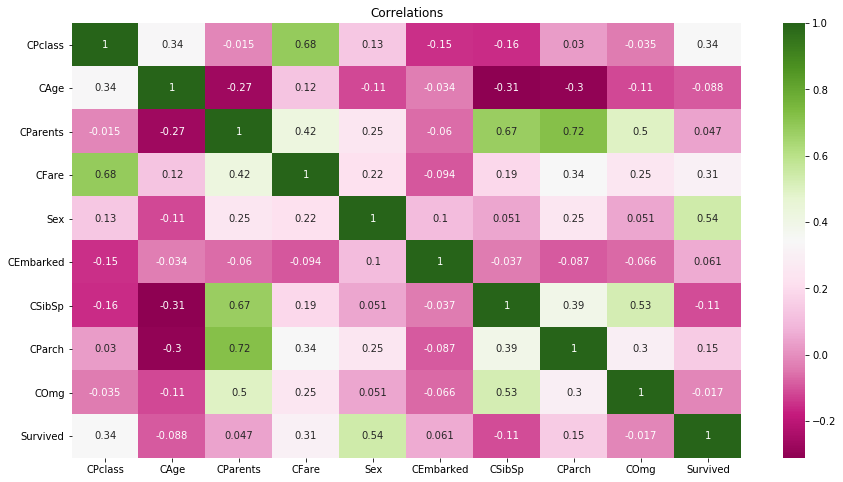

In [54]:
plt.subplots(figsize=[15, 8])
sns.heatmap(analyse.corr(), annot=True, cmap='PiYG')
plt.title('Correlations')

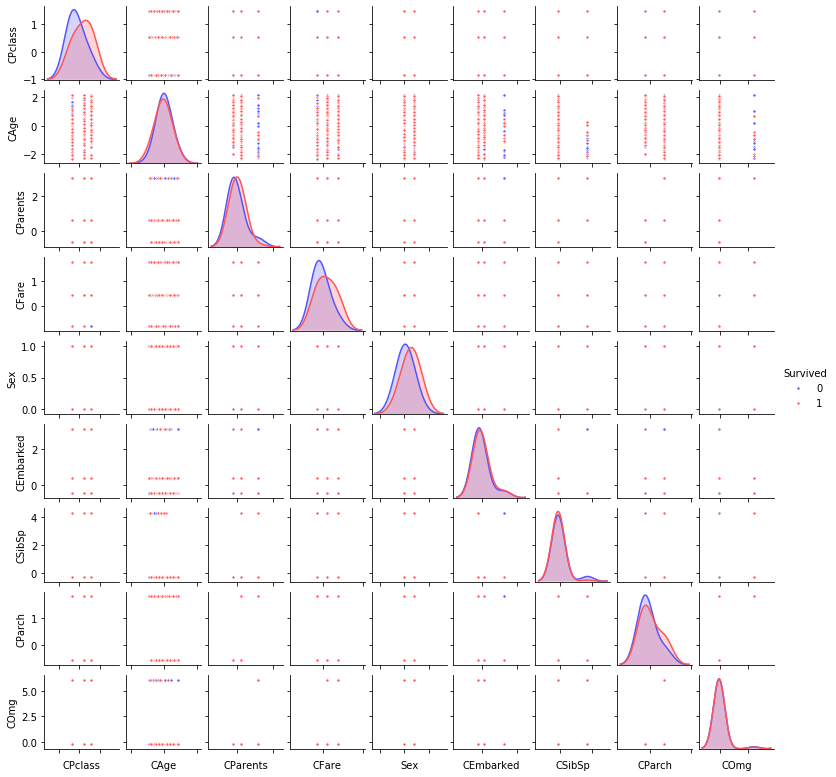

In [55]:
g = sns.pairplot(data=analyse, hue='Survived', palette = 'seismic',
                 height=1.2,diag_kind = 'kde',diag_kws=dict(shade=True, bw=1),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [56]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(X, y)
# X = train_data[features]
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [57]:
models = {}
def create_model(name, model):
    scoring='accuracy'
    scores = cross_val_score(model, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
    model.fit(X,y)
    print("[%s] Accuracy: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))
    return model

In [58]:
models['RandomForest'] = create_model('RandomForest', RandomForestClassifier())

[RandomForest] Accuracy: 0.81 (+/- 0.06)


In [59]:
models['SVM'] = create_model('SVM', svm.SVC())

[SVM] Accuracy: 0.82 (+/- 0.03)


In [60]:
models['Gaussian'] = create_model('Gaussian', GaussianNB())

[Gaussian] Accuracy: 0.80 (+/- 0.06)


In [61]:
models['LogisticRegression'] = create_model('LogisticRegression', LogisticRegression(max_iter=300))

[LogisticRegression] Accuracy: 0.81 (+/- 0.03)


In [62]:
models['KNN'] = create_model('KNN', KNeighborsClassifier(n_neighbors=7))

[KNN] Accuracy: 0.81 (+/- 0.04)


In [63]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [64]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, confusion_matrix 
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
# grid.fit(X_train,y_train)
# print(grid.best_estimator_)

# grid_predictions = grid.predict(X_test)
# print(confusion_matrix(y_test,grid_predictions))
# print(classification_report(y_test,grid_predictions))

In [65]:
# 

test_data['Omg'] = 0
groups = test_data.groupby('Ticket').groups
# pairs = list(filter(lambda x: groups[x].size >= 2, groups))
for group in groups:
    if(groups[group].size >= 2 ):
        for pearson in groups[group]:
            info = test_data.loc[pearson]
            corr = info['Parch'] + info['SibSp']
            if(corr > groups[group].size):
                test_data.at[pearson, 'Omg'] = corr
                
test_data['COmg'] = test_data['Omg'].map(transform_omg)
# test_data['COmg'] = test_data['COmg'].map(omg_mapping)
test_data['COmg'] = omg_scaller.transform(test_data['COmg'].values.reshape(-1,1))
                
                

# Title
test_names = test_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_names
test_data['CTitle'] = test_names.map(title_mapping)
test_data['CTitle'] = title_scaller.transform(test_data['CTitle'].values.reshape(-1,1))

# Fare
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data = test_data.apply(fare_outliers, axis=1)
test_data['CFare'] = test_data['Fare'].map(transform_fare)
test_data['CFare'] = test_data['CFare'].map(fare_mapping)
test_data['CFare'] = fare_scaller.transform(test_data['CFare'].values.reshape(-1,1))

# Sex
test_data['Sex'] = test_data.Sex.map(sex_mapping)

# Embarked
test_data['CEmbarked'] = test_data.Embarked.map(embarked_mapping)
test_data['CEmbarked'] = embarked_scaller.transform(test_data['CEmbarked'].values.reshape(-1,1))

# Age
test_data = test_data.apply(median_age, axis=1)
test_data = test_data.apply(age_outliers, axis=1)
# test_data['CAge'] = age_scaller.transform(test_data['Age'].values.reshape(-1,1))
test_data['CGAge'] = test_data['Age'].map(transform_age)
test_data['CAge'] = test_data['CGAge'].map(age_mapping)
test_data['CAge'] = age_scaller.transform(test_data['CAge'].values.reshape(-1,1))

# Parents
test_data['Parents'] = test_data['Parch'] + test_data['SibSp']
test_data['CGParents'] = test_data['Parents'].map(transform_parent)
test_data['CParents'] = test_data['CGParents'].map(parent_mapping)
test_data['CParents'] = parent_scaller.transform(test_data['CParents'].values.reshape(-1,1))

# Class
test_data['CPclass'] = test_data['Pclass'].map(class_mapping)
test_data['CPclass'] = class_scaller.transform(test_data['CPclass'].values.reshape(-1,1))

# SibSp
test_data['CGSibSp'] = test_data['SibSp'].map(transform_sibsp)
# test_data['CSibSp'] = test_data['SibSp'].map(transform_sibsp)
test_data['CSibSp'] = sibsp_scaller.transform(test_data['CGSibSp'].values.reshape(-1,1))

# Parch
test_data['CGParch'] = test_data['Parch'].map(transform_parch)
# test_data['CParch'] = test_data['Parch'].map(transform_parch)
test_data['CParch'] = parch_scaller.fit_transform(test_data['CGParch'].values.reshape(-1,1))

In [66]:
Xtrain = test_data[features]

In [67]:
inputs = scaler.transform(Xtrain)
# inputs = Xtrain

model = models['SVM']
# inputs = test_data
prediction = model.predict(inputs)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": prediction
    })

filename = 'titanic-testar-esse.csv'
submission.to_csv('predictions/'+filename, index=False)

In [ ]:
new_file = 'predictions/'+filename
best_file = 'predictions/all-std-svm.csv'

df1 = pd.read_csv(new_file)
df2 = pd.read_csv(best_file)



result = pd.DataFrame(columns=['PassengerId'])
df1['isEqual'] = np.where(df1['Survived'] == df2['Survived'],1,0)

df1[df1['isEqual']== 0]['PassengerId'].values


In [ ]:
# SVM-SINGLE
# array([ 893,  896,  910,  915,  924,  925,  928,  929,  941,  964,  979,
#         980,  982,  990, 1017, 1030, 1041, 1045, 1049, 1051, 1057, 1061,
#        1073, 1089, 1091, 1109, 1134, 1136, 1160, 1172, 1185, 1198, 1200,
#        1201, 1236, 1237, 1251, 1259, 1268, 1274, 1275, 1299, 1304])


#([ 893,  896,  910,  924,  925,  928,  929,  941,  964,  979,  980,
#         982,  990, 1017, 1024, 1030, 1045, 1049, 1051, 1057, 1061, 1089,
#        1091, 1136, 1160, 1172, 1185, 1201, 1236, 1237, 1251, 1257, 1259,
#        1268, 1274, 1275, 1304])

#array([ 911, 1117, 1141, 1231, 1239, 1281])
diference = test_data.iloc[df1[df1['isEqual']== 0]['PassengerId'].index, :]
# diference['Age'].max()
diference[['Omg', 'Parch', 'SibSp']].head(50)


In [ ]:
train_data['Omg'] = 0
groups = train_data.groupby('Ticket').groups
for group in groups:
    if(groups[group].size >=2 ):
#         print(group, groups[group])
        for pearson in groups[group]:
            info = train_data.loc[pearson]
            corr = info['Parch'] + info['SibSp']
#             if(corr < groups[group].size):
#                 print(info['Ticket'], info['Name'], info['Parch'], info['SibSp'])
#                 train_data.loc[pearson] = train_data.loc[pearson]['Omg'] = corr
#                     train_data.at[pearson, 'Omg'] = corr
            
#         print('------')

train_data['Omg'].value_counts()

In [ ]:
class_distribuition(train_data, 'COmg')